In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figsize=(9, 7)):
    matrix = confusion_matrix(y_true, y_pred)

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 size=int((figsize[0] / 10) * 38),
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [57]:
train = pd.read_csv("split/train.csv")
dev = pd.read_csv("split/dev.csv")
test = pd.read_csv("split/test.csv")

In [4]:
max_len = 40
TEXT = "aliased_snippet"
RESULT = "is_parent"

In [5]:
import pickle
tokenizer = None
with open("tokenizers/tokenizer50k.pickle", "rb") as handle:
        tokenizer = pickle.load(handle)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
def add_company_pos_ratio(company, row): 
    index= row[TEXT].find(company)
    if index < 0:
        return 1
    return index / len(row[TEXT])

from sklearn.base import TransformerMixin,  BaseEstimator
class RatioPos(TransformerMixin,BaseEstimator):
    def __init__(self, company):
        self.company = company
    def transform(self, X, **kwargs):
        return X.apply((lambda x: add_company_pos_ratio(self.company, x)), axis=1).values
    def fit(self, X, y=None, **kwargs):
        return self

In [37]:
from keras.preprocessing.sequence import pad_sequences
def create_features(data):
    data_seq = pad_sequences(tokenizer.texts_to_sequences(data[TEXT]), maxlen=max_len)
    company1_pos = RatioPos("company1").fit_transform(data).reshape( (-1,1) )
    company2_pos = RatioPos("company2").fit_transform(data).reshape( (-1,1) )
    data_pos = np.hstack((company1_pos, company2_pos))
    return [data_seq, data_pos]

In [8]:
create_features(train)

[array([[   0,    0,    0, ...,  984,    2,    5],
        [   0,    0,    0, ...,  111,   64,    5],
        [   0,    0,    0, ...,   11, 1690,    5],
        ...,
        [   0,    0,    0, ...,    2,  118,    5],
        [3150,    4,    3, ..., 9734, 1497,    5],
        [   0,    0,    0, ..., 6138, 1862,    5]], dtype=int32),
 array([[0.08888889, 0.25185185],
        [0.65470852, 0.38565022],
        [0.29775281, 0.83707865],
        ...,
        [0.68      , 0.33333333],
        [0.33870968, 0.06129032],
        [0.19915254, 0.25423729]])]

In [38]:
def load_vectors(path, dim):
    with open(path) as lines:
        w2v = {line.split()[0]: np.array( list( map(float,line.split()[1:]) ))
           for line in lines}
        embedding_matrix = np.zeros((len(w2v) + 1, dim))
        for i,word in enumerate(w2v):
            embedding_vector = w2v[word]
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
        return w2v, embedding_matrix

In [39]:
w2v, embedding_matrix = load_vectors("/home/radoslav/git/neuroner/NeuroNER-master/data/word_vectors/glove.6B.100d.txt", 100)

In [40]:
from keras.layers import Dense, Convolution1D, MaxPooling1D, Dropout, Input, Embedding, LSTM, Bidirectional, GlobalMaxPooling1D, concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping

In [46]:
def create_model1():
    seq_input = Input(shape=(max_len,))
    x = Embedding(output_dim=100,input_dim=len(w2v)+1,trainable=False, input_length=max_len, weights=[embedding_matrix])(seq_input)
    lstm = Bidirectional(LSTM(200, return_sequences=True))(x)
    lstm =  GlobalMaxPooling1D()(lstm)
    
    pos_input = Input(shape=(2,))
    
    x = concatenate([lstm, pos_input])
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dropout(0.1)(x)
    output = Dense(1, activation="sigmoid")(x)
    
    model = Model(inputs=[seq_input, pos_input], outputs=[output])
    return model
    
model = create_model1()

In [51]:
model.summary()
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 40, 100)      40000100    input_20[0][0]                   
__________________________________________________________________________________________________
bidirectional_8 (Bidirectional) (None, 40, 400)      481600      embedding_12[0][0]               
__________________________________________________________________________________________________
global_max_pooling1d_3 (GlobalM (None, 400)          0           bidirectional_8[0][0]            
__________________________________________________________________________________________________
input_21 (

In [52]:
early_stoping = EarlyStopping(patience=2)
model.fit(create_features(train), train[RESULT],validation_data=(create_features(dev), dev[RESULT]),class_weight={0: 0.4, 1: 0.6}, batch_size=64, epochs=10, callbacks=[early_stoping])

Train on 55568 samples, validate on 15876 samples
Epoch 1/10
55568/55568 [==============================] - 59s 1ms/step - loss: 0.0878 - acc: 0.9203 - val_loss: 0.5342 - val_acc: 0.8200
Epoch 2/10
55568/55568 [==============================] - 58s 1ms/step - loss: 0.0668 - acc: 0.9428 - val_loss: 0.5427 - val_acc: 0.8144
Epoch 3/10
55568/55568 [==============================] - 58s 1ms/step - loss: 0.0570 - acc: 0.9519 - val_loss: 0.4792 - val_acc: 0.8217
Epoch 4/10
55568/55568 [==============================] - 58s 1ms/step - loss: 0.0484 - acc: 0.9603 - val_loss: 0.6254 - val_acc: 0.8354
Epoch 5/10
55568/55568 [==============================] - 58s 1ms/step - loss: 0.0373 - acc: 0.9698 - val_loss: 0.6142 - val_acc: 0.8357


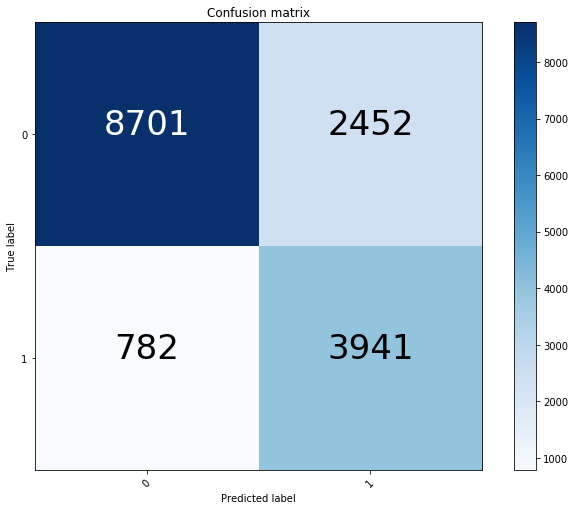

F1 score of test is 0.7090680100755667


In [49]:
score_model_on(model, dev)

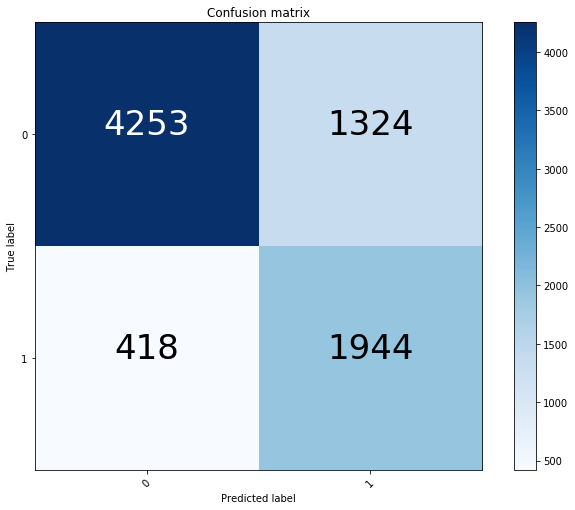

F1 score of test is 0.6905861456483126


In [50]:
score_model_on(model, test)

In [67]:
model.save("bi_lstm_pos_790f1.h5")

In [70]:
model = create_model1()
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [71]:
early_stoping = EarlyStopping(patience=2)
model.fit(create_features(train.append(dev)), train[RESULT].append(dev[RESULT]),validation_data=(create_features(test), test[RESULT]), batch_size=64, epochs=10, callbacks=[early_stoping])

Train on 71444 samples, validate on 7939 samples
Epoch 1/10
71444/71444 [==============================] - 94s 1ms/step - loss: 0.4419 - acc: 0.7898 - val_loss: 0.3324 - val_acc: 0.8555
Epoch 2/10
71444/71444 [==============================] - 91s 1ms/step - loss: 0.2385 - acc: 0.9058 - val_loss: 0.2669 - val_acc: 0.8897
Epoch 3/10
71444/71444 [==============================] - 92s 1ms/step - loss: 0.1337 - acc: 0.9495 - val_loss: 0.2772 - val_acc: 0.8967
Epoch 4/10
71444/71444 [==============================] - 92s 1ms/step - loss: 0.0820 - acc: 0.9685 - val_loss: 0.3309 - val_acc: 0.8971


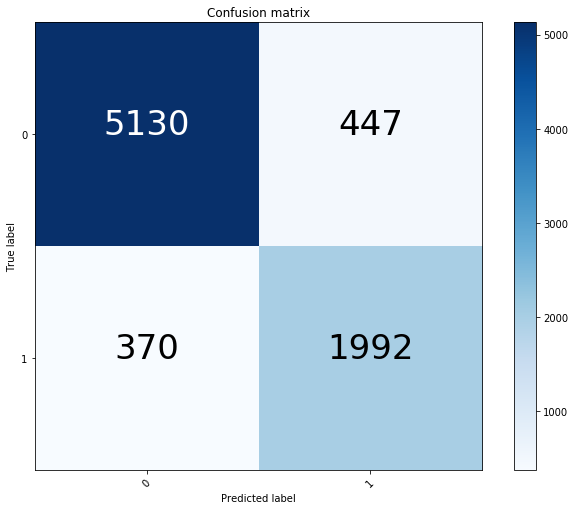

F1 score of test is 0.8298271193501354


In [72]:
score_model_on(model, test)

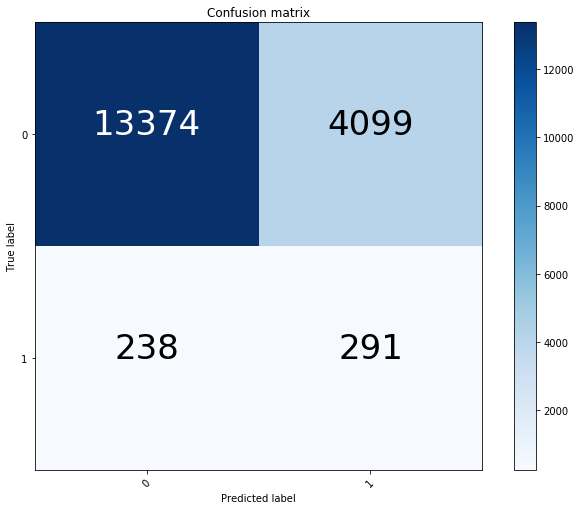

F1 score of test is 0.11831673104289489


In [73]:
onto_test = pd.read_csv("processed/test.csv")
score_model_on(model, onto_test)

In [41]:
def create_model():
    seq_input = Input(shape=(max_len,))
    x = Embedding(output_dim=128,input_dim=tokenizer.num_words, input_length=max_len)(seq_input)
    lstm = Bidirectional(LSTM(200, return_sequences=True))(x)
    lstm = Bidirectional(LSTM(64, return_sequences=True))(lstm)
    lstm =  GlobalMaxPooling1D()(lstm)
    
    pos_input = Input(shape=(2,))
    
    x = concatenate([lstm, pos_input])
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dropout(0.1)(x)
    output = Dense(1, activation="sigmoid")(x)
    
    model = Model(inputs=[seq_input, pos_input], outputs=[output])
    return model
    
model = create_model()

In [42]:
model.summary()
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 40, 128)      6400000     input_12[0][0]                   
__________________________________________________________________________________________________
bidirectional_8 (Bidirectional) (None, 40, 400)      526400      embedding_8[0][0]                
__________________________________________________________________________________________________
bidirectional_9 (Bidirectional) (None, 40, 128)      238080      bidirectional_8[0][0]            
__________________________________________________________________________________________________
global_max

In [43]:
early_stoping = EarlyStopping(patience=2)
model.fit(create_features(train), train[RESULT],validation_data=(create_features(dev), dev[RESULT]), batch_size=64, epochs=10, callbacks=[early_stoping])

Train on 55568 samples, validate on 15876 samples
Epoch 1/10
55568/55568 [==============================] - 137s 2ms/step - loss: 0.4881 - acc: 0.7619 - val_loss: 0.3661 - val_acc: 0.8355
Epoch 2/10
55568/55568 [==============================] - 136s 2ms/step - loss: 0.2774 - acc: 0.8880 - val_loss: 0.3067 - val_acc: 0.8742
Epoch 3/10
55568/55568 [==============================] - 133s 2ms/step - loss: 0.1558 - acc: 0.9419 - val_loss: 0.3283 - val_acc: 0.8658
Epoch 4/10
55568/55568 [==============================] - 134s 2ms/step - loss: 0.0898 - acc: 0.9670 - val_loss: 0.3984 - val_acc: 0.8819


In [23]:
from sklearn.metrics import f1_score
def score_model_on(model, data):
    predictions = model.predict(create_features(data))    
    predictions_binary = np.round(predictions)
    plot_confusion_matrix(data[RESULT], predictions_binary,classes=[0,1], normalize=False) 
    print("F1 score of test is {}".format(f1_score(data[RESULT], predictions_binary)))

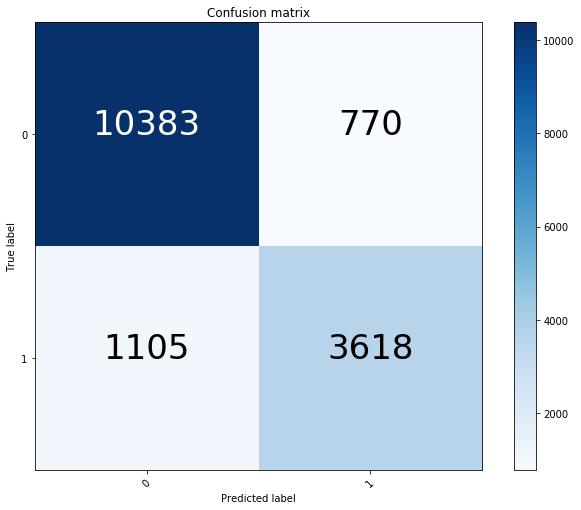

F1 score of test is 0.7942048073756999


In [44]:
score_model_on(model, dev)

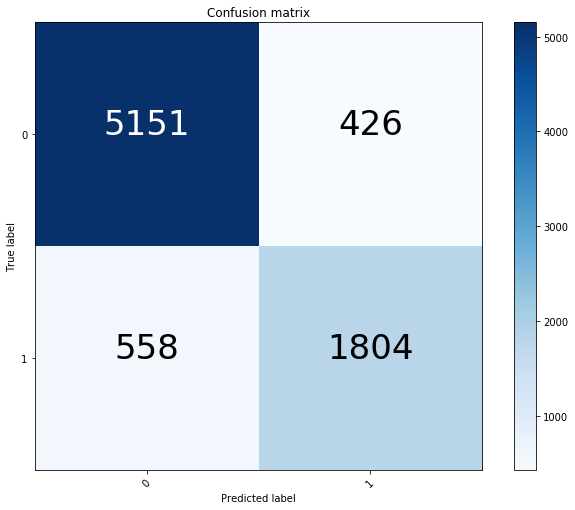

F1 score of test is 0.7857142857142857


In [45]:
score_model_on(model, test)

In [46]:
model.save("bi_lstm_pos_stacked_785f1.h5")

In [50]:
train_dev_model = create_model()
train_dev_model.summary()
train_dev_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 40, 128)      6400000     input_20[0][0]                   
__________________________________________________________________________________________________
bidirectional_16 (Bidirectional (None, 40, 400)      526400      embedding_12[0][0]               
__________________________________________________________________________________________________
bidirectional_17 (Bidirectional (None, 40, 128)      238080      bidirectional_16[0][0]           
__________________________________________________________________________________________________
global_max

In [53]:
early_stoping = EarlyStopping(patience=2)
train_dev_model.fit(create_features(train.append(dev)), train[RESULT].append(dev[RESULT]),validation_data=(create_features(test), test[RESULT]), batch_size=64, epochs=10, callbacks=[early_stoping])

Train on 71444 samples, validate on 7939 samples
Epoch 1/10
71444/71444 [==============================] - 163s 2ms/step - loss: 0.4681 - acc: 0.7730 - val_loss: 0.3271 - val_acc: 0.8556
Epoch 2/10
71444/71444 [==============================] - 161s 2ms/step - loss: 0.2487 - acc: 0.9007 - val_loss: 0.2822 - val_acc: 0.8869
Epoch 3/10
71444/71444 [==============================] - 160s 2ms/step - loss: 0.1421 - acc: 0.9466 - val_loss: 0.2903 - val_acc: 0.8994
Epoch 4/10
71444/71444 [==============================] - 159s 2ms/step - loss: 0.0839 - acc: 0.9690 - val_loss: 0.3507 - val_acc: 0.8948


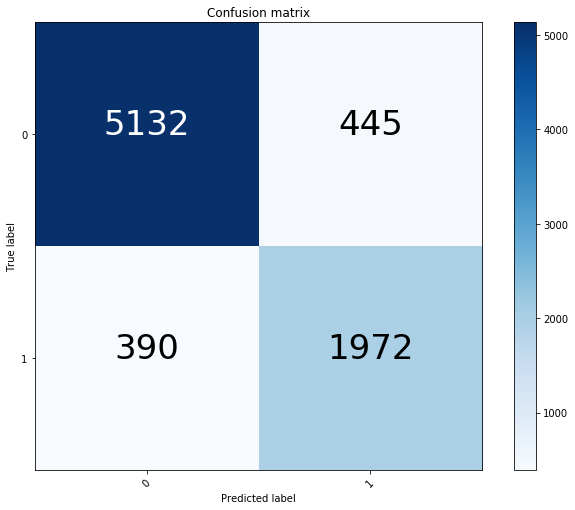

F1 score of test is 0.8252772546557858


In [54]:
score_model_on(train_dev_model, test)

In [55]:
train_dev_model.save("bi_lstm_train_dev_825f1.h5")

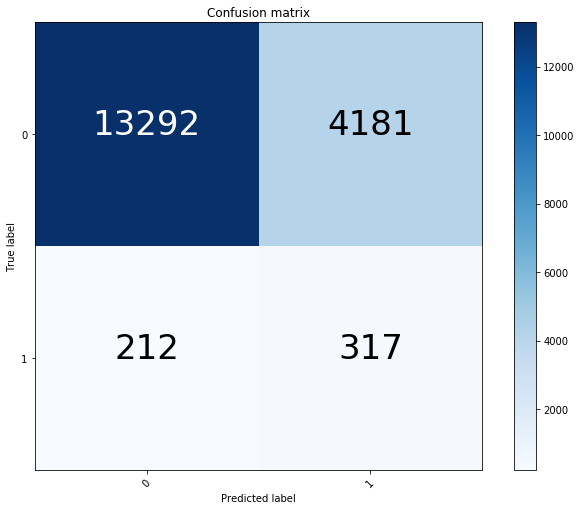

F1 score of test is 0.12611895762880448


In [58]:
onto_test = pd.read_csv("processed/test.csv")
score_model_on(train_dev_model, onto_test)